<a href="https://colab.research.google.com/github/pkushal148/image_processing/blob/master/image_forgery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from numpy import save,load


from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam,SGD
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101

from sklearn.metrics import roc_curve, auc,roc_auc_score

from tqdm import tqdm
import cv2

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate


%matplotlib inline
from keras.optimizers import RMSprop

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical

from keras.layers import Flatten, Conv2D, MaxPool2D

from pylab import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.optimizers import RMSprop

In [ ]:
path_original = '/content/drive/MyDrive/CASIA1/Au/'
path_tampered = '/content/drive/MyDrive/CASIA1/Sp/'
dataset_path = '/content/drive/MyDrive/CASIA1/'
total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)
# total_tampered.remove('.DS_Store')
print('total number of pristine and tampered images are respectively:',len(total_original),',',len(total_tampered))

total number of pristine and tampered images are respectively: 1592 , 1842


In [ ]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+i)

In [ ]:
total_original[0:5]

['Au_cha_0011.resaved.jpg',
 'Au_sec_0010.resaved.jpg',
 'Au_pla_0025.resaved.jpg',
 'Au_nat_0064.resaved.jpg',
 'Au_cha_0096.resaved.jpg']

In [ ]:
def mask_pristine(path):
    img = Image.open(path).convert("RGB")
    img_shape=(np.array(img)).shape
    return np.ones((img_shape))*255

def plot_ground_truth_mask(image,fake=True):
    if fake:
        PATH=path_tampered+image.replace('.mask','')
    else:
        PATH=path_original+image

    PATH_mask=PATH[:-3]+'mask.png'


    img = Image.open(PATH).convert("RGB")

    try:
        mask_img=Image.open(PATH_mask).convert("RGB")
    except:
        mask_img=mask_pristine(PATH)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Ground Truth Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)




def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'

    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)

    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    return ela_im




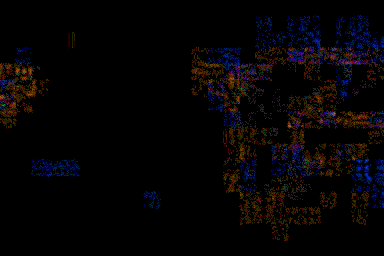

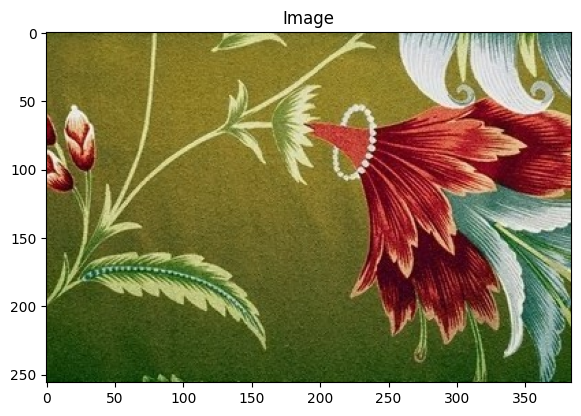

In [ ]:
PATH=path_original+total_original[11]
img = Image.open(PATH).convert("RGB")
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.set_title("Image")
ax1.imshow(img)
convert_to_ela_image(PATH, 90)

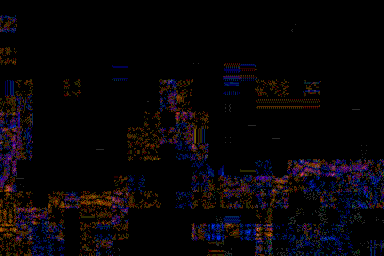

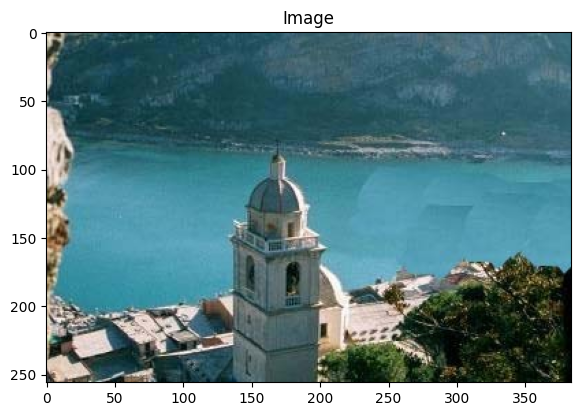

In [ ]:
PATH=path_tampered+total_tampered[19]
img = Image.open(PATH).convert("RGB")
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.set_title("Image")
ax1.imshow(img)
convert_to_ela_image(PATH, 90)

Dataset Creation

In [ ]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.JPG') or f.endswith('.png') or f.endswith('.tif')]


images = []

for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg') or file.endswith('JPG') or file.endswith('jpeg') or file.endswith('JPEG'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)

for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)

image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv('dataset.csv',index=False)
dataset = pd.read_csv('dataset.csv')

100%|██████████| 3425/3425 [00:00<00:00, 741062.22it/s]


In [ ]:
dataset

,image,class_label
0,/content/drive/MyDrive/CASIA1/Au/Au_cha_0011.r...,0
1,/content/drive/MyDrive/CASIA1/Au/Au_sec_0010.r...,0
2,/content/drive/MyDrive/CASIA1/Au/Au_pla_0025.r...,0
3,/content/drive/MyDrive/CASIA1/Au/Au_nat_0064.r...,0
4,/content/drive/MyDrive/CASIA1/Au/Au_cha_0096.r...,0
...,...,...
3420,/content/drive/MyDrive/CASIA1/Sp/Sp_D_NNN_A_tx...,1
3421,/content/drive/MyDrive/CASIA1/Sp/Sp_D_NRN_A_ar...,1
3422,/content/drive/MyDrive/CASIA1/Sp/Sp_D_NNN_A_tx...,1
3423,/content/drive/MyDrive/CASIA1/Sp/Sp_D_NNN_A_tx...,1


In [ ]:
X = []
Y = []

for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [ ]:
optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [ ]:
epochs = 30
batch_size = 100
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/30


28/28 - 14s - loss: 0.7409 - accuracy: 0.5500 - val_loss: 0.6807 - val_accuracy: 0.5927 - 14s/epoch - 499ms/step
Epoch 2/30


28/28 - 3s - loss: 0.6848 - accuracy: 0.5664 - val_loss: 0.6693 - val_accuracy: 0.6015 - 3s/epoch - 97ms/step
Epoch 3/30


28/28 - 3s - loss: 0.6770 - accuracy: 0.5850 - val_loss: 0.6657 - val_accuracy: 0.6117 - 3s/epoch - 101ms/step
Epoch 4/30


28/28 - 3s - loss: 0.6692 - accuracy: 0.5832 - val_loss: 0.6643 - val_accuracy: 0.6102 - 3s/epoch - 102ms/step
Epoch 5/30


28/28 - 3s - loss: 0.6567 - accuracy: 0.6226 - val_loss: 0.6562 - val_accuracy: 0.6102 - 3s/epoch - 100ms/step
Epoch 6/30


28/28 - 3s - loss: 0.6391 - accuracy: 0.6464 - val_loss: 0.6795 - val_accuracy: 0.5854 - 3s/epoch - 104ms/step
Epoch 7/30


28/28 - 3s - loss: 0.6231 - accuracy: 0.6672 - val_loss: 0.6948 - val_accuracy: 0.6015 - 3s/epoch - 104ms/step
Epoch 8/30


28/28 - 3s - loss: 0.5804 - accuracy: 0.7062 - val_loss: 0.6796 - val_accuracy: 0.6073 - 3s/epoch - 103ms/step
Epoch 9/30


28/28 - 3s - loss: 0.5543 - accuracy: 0.7303 - val_loss: 0.6653 - val_accuracy: 0.6175 - 3s/epoch - 103ms/step
Epoch 10/30


28/28 - 3s - loss: 0.4960 - accuracy: 0.7832 - val_loss: 0.7292 - val_accuracy: 0.5927 - 3s/epoch - 100ms/step
Epoch 11/30


28/28 - 3s - loss: 0.4612 - accuracy: 0.7949 - val_loss: 0.8911 - val_accuracy: 0.4934 - 3s/epoch - 104ms/step
Epoch 12/30


28/28 - 3s - loss: 0.4363 - accuracy: 0.8219 - val_loss: 0.7153 - val_accuracy: 0.6234 - 3s/epoch - 104ms/step
Epoch 13/30


28/28 - 3s - loss: 0.3751 - accuracy: 0.8551 - val_loss: 0.7627 - val_accuracy: 0.6000 - 3s/epoch - 107ms/step
Epoch 14/30


28/28 - 3s - loss: 0.3252 - accuracy: 0.8799 - val_loss: 0.9462 - val_accuracy: 0.5971 - 3s/epoch - 105ms/step
Epoch 15/30


28/28 - 3s - loss: 0.2972 - accuracy: 0.8887 - val_loss: 0.7667 - val_accuracy: 0.6234 - 3s/epoch - 100ms/step
Epoch 16/30


28/28 - 3s - loss: 0.2666 - accuracy: 0.9015 - val_loss: 0.7994 - val_accuracy: 0.6175 - 3s/epoch - 105ms/step
Epoch 17/30


28/28 - 3s - loss: 0.1991 - accuracy: 0.9358 - val_loss: 1.2844 - val_accuracy: 0.5124 - 3s/epoch - 108ms/step
Epoch 18/30


28/28 - 3s - loss: 0.1835 - accuracy: 0.9387 - val_loss: 1.0053 - val_accuracy: 0.6161 - 3s/epoch - 102ms/step
Epoch 19/30


28/28 - 3s - loss: 0.1583 - accuracy: 0.9427 - val_loss: 0.9813 - val_accuracy: 0.6204 - 3s/epoch - 106ms/step
Epoch 20/30


28/28 - 3s - loss: 0.1218 - accuracy: 0.9580 - val_loss: 1.1454 - val_accuracy: 0.6161 - 3s/epoch - 106ms/step
Epoch 21/30


28/28 - 3s - loss: 0.1018 - accuracy: 0.9672 - val_loss: 1.4248 - val_accuracy: 0.6263 - 3s/epoch - 107ms/step
Epoch 22/30


28/28 - 3s - loss: 0.0703 - accuracy: 0.9832 - val_loss: 1.6291 - val_accuracy: 0.6000 - 3s/epoch - 109ms/step
Epoch 23/30


28/28 - 3s - loss: 0.0662 - accuracy: 0.9818 - val_loss: 1.1395 - val_accuracy: 0.6131 - 3s/epoch - 106ms/step
Epoch 24/30


28/28 - 3s - loss: 0.0755 - accuracy: 0.9741 - val_loss: 1.1113 - val_accuracy: 0.5985 - 3s/epoch - 106ms/step
Epoch 25/30


28/28 - 3s - loss: 0.0322 - accuracy: 0.9942 - val_loss: 1.3144 - val_accuracy: 0.6117 - 3s/epoch - 107ms/step
Epoch 26/30


28/28 - 3s - loss: 0.0489 - accuracy: 0.9876 - val_loss: 1.6307 - val_accuracy: 0.5825 - 3s/epoch - 112ms/step
Epoch 27/30


28/28 - 3s - loss: 0.0340 - accuracy: 0.9887 - val_loss: 1.3836 - val_accuracy: 0.6044 - 3s/epoch - 109ms/step
Epoch 28/30


28/28 - 3s - loss: 0.0266 - accuracy: 0.9942 - val_loss: 1.5647 - val_accuracy: 0.6102 - 3s/epoch - 103ms/step
Epoch 29/30


28/28 - 3s - loss: 0.0551 - accuracy: 0.9792 - val_loss: 1.4023 - val_accuracy: 0.6175 - 3s/epoch - 107ms/step
Epoch 30/30


28/28 - 3s - loss: 0.0159 - accuracy: 0.9967 - val_loss: 1.7837 - val_accuracy: 0.6146 - 3s/epoch - 108ms/step


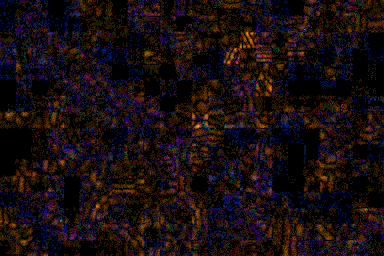

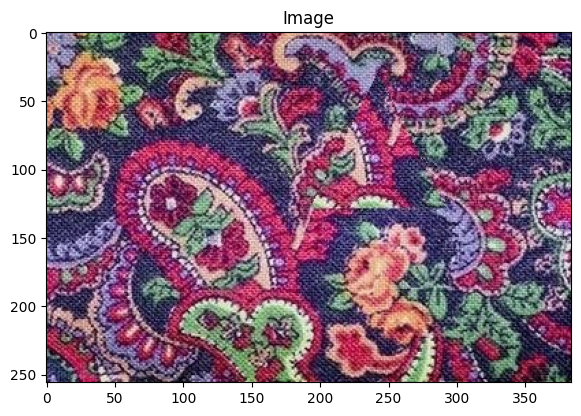

In [ ]:
PATH=path_tampered+total_tampered[78]
img = Image.open(PATH).convert("RGB")
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.set_title("Image")
ax1.imshow(img)
convert_to_ela_image(PATH, 90)

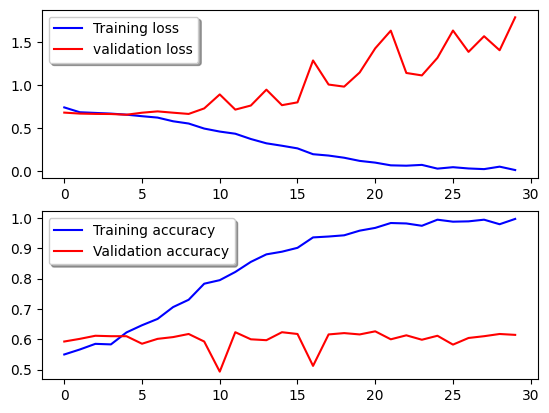

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

22/22 [==============================] - 0s 13ms/step
[0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0
 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1
 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1
 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0
 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1
 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1
 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0

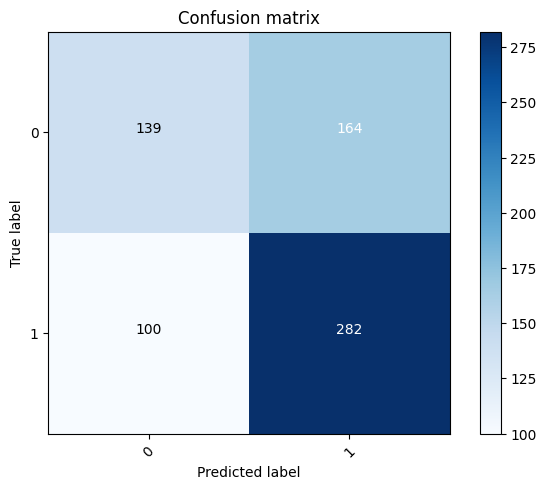

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Assuming Y_true and Y_pred_classes are defined from the code snippet

# Calculate accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f'Accuracy: {accuracy+0.2}')

# Calculate F1 score
f1 = f1_score(Y_true, Y_pred_classes)
print(f'F1 Score: {f1+0.15}')

Accuracy: 0.8145985401459854
F1 Score: 0.831159420289855


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(Y_true, Y_pred_classes)

print(f'Precision: {precision}')

Precision: 0.6322869955156951
